## Module 2 Homework

In this homework, we're going to combine data from various sources to process it in Pandas and generate additional fields.

If not stated otherwise, please use the [LINK](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/02-dataframe-analysis/%5B2025%5D_Module_02_Colab_Working_with_the_data.ipynb) covered at the livestream to re-use the code snippets.

---

---
### Question 1: [IPO] Withdrawn IPOs by Company Type

**What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?**

From the withdrawn IPO list ([stockanalysis.com/ipos/withdrawn](https://stockanalysis.com/ipos/withdrawn/)), collect and process the data to find out which company type saw the most withdrawn IPO value.

#### Steps:
1. Use `pandas.read_html()` with the URL above to load the IPO withdrawal table into a DataFrame. 
   *It is a similar process to Code Snippet 1 discussed at the livestream.*    You should get **99 entries**. 
2. Create a new column called `Company Class`, categorizing company names based on patterns like:
   - “Acquisition Corp” or “Acquisition Corporation” → `Acq.Corp`
   - “Inc” or “Incorporated” → `Inc`
   - “Group” → `Group`
   - “Holdings” → `Holdings`
   - “Ltd” or “Limited” → `Ltd`
   - Others → `Other`

  * Hint: make your function more robust by converting names to lowercase and splitting into words before matching patterns.

3. Define a new field `Avg. price` by parsing the `Price Range` field (create a function and apply it to the `Price Range` column). Examples:
   - '$8.00-$10.00' → `9.0`  
   - '$5.00' → `5.0`  
   - '-' → `None`
4. Convert `Shares Offered` to numeric, clean missing or invalid values.
5. Create a new column:  
   `Withdrawn Value = Shares Offered * Avg Price` (**71 non-null values**)
6. Group by `Company Class` and calculate total withdrawn value.
7. **Answer**: Which class had the highest **total** value of withdrawals?
---

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import requests


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt
     

In [2]:

import pandas as pd
import requests
from io import StringIO

def get_ipos(url):
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/withdrawn"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [3]:
ipo_wdr = get_ipos("https://stockanalysis.com/ipos/withdrawn")

print(ipo_wdr.info())
print(ipo_wdr.isnull().sum())

ipo_wdr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Symbol          100 non-null    object
 1   Company Name    100 non-null    object
 2   Price Range     100 non-null    object
 3   Shares Offered  100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB
None
Symbol            0
Company Name      0
Price Range       0
Shares Offered    0
dtype: int64


,Symbol,Company Name,Price Range,Shares Offered
0,ODTX,"Odyssey Therapeutics, Inc.",-,-
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000
2,AURN,"Aurion Biotech, Inc.",-,-
3,ROTR,"PHI Group, Inc.",-,-
4,ONE,One Power Company,-,-


In [4]:
def classify_company(name):
    name = name.lower()
    if "acquisition corp" in name or "acquisition corporation" in name:
        return "Acq.Corp"
    elif "inc" in name or "incorporated" in name:
        return "Inc"
    elif "group" in name:
        return "Group"
    elif "holdings" in name:
        return "Holdings"
    elif "ltd" in name or "limited" in name:
        return "Ltd"
    else:
        return "Other"



import numpy as np
import re

def extract_price(price_range):
    # Handle empty or '--' cases
    if pd.isna(price_range) or price_range == '--':
        return np.nan
    
    # Remove $ and M characters
    cleaned_price = price_range.replace('$', '').replace('M', '')
    
    # Check if it's a range (contains a hyphen)
    if '-' in cleaned_price:
        # Extract the two values from the range
        values = re.findall(r'\d+\.?\d*', cleaned_price)
        if len(values) >= 2:
            # Calculate midpoint
            return (float(values[0]) + float(values[1])) / 2
    else:
        # For absolute values
        values = re.findall(r'\d+\.?\d*', cleaned_price)
        if values:
            return float(values[0])
    
    # Fallback if no numbers found
    return np.nan






In [5]:
ipo_wdr["Company Class"] = ipo_wdr["Company Name"].apply(classify_company)

ipo_wdr["Amount"] = ipo_wdr["Price Range"].apply(extract_price)

ipo_wdr["Shares Offered"] = pd.to_numeric(ipo_wdr["Shares Offered"], errors='coerce')

# Amount is already the average price from your previous step
ipo_wdr["Withdrawn Value"] = ipo_wdr["Shares Offered"] * ipo_wdr["Amount"]

# 3. Group by 'Company Class' and calculate total withdrawn value
class_totals = ipo_wdr.groupby("Company Class")["Withdrawn Value"].sum().sort_values(ascending=False)

# 4. Find the class with the highest total withdrawn value
highest_class = class_totals.index[0]
highest_value = class_totals.iloc[0]

print(f"Class totals (in descending order):\n{class_totals}")
print(f"\nThe class with the highest total value of withdrawals is: {highest_class}")
print(f"Total withdrawn value: {highest_value:,.2f}")

Class totals (in descending order):
Company Class
Acq.Corp    4.021000e+09
Inc         2.257164e+09
Other       7.679200e+08
Ltd         3.217346e+08
Holdings    3.030000e+08
Group       3.378750e+07
Name: Withdrawn Value, dtype: float64

The class with the highest total value of withdrawals is: Acq.Corp
Total withdrawn value: 4,021,000,000.00


### Question 2:   [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)


**What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?**

The goal is to replicate the large-scale `yfinance` OHLCV data download and perform basic financial calculations on IPO stocks.


#### Steps:

1. Using the same approach as in Question 1, download the IPOs in 2024 from:  
   [https://stockanalysis.com/ipos/2024/](https://stockanalysis.com/ipos/2024/)  
   Filter to keep only those IPOs **before 1 June 2024** (first 5 months of 2024).  
   ➤ You should have **75 tickers**.

2.  Use **Code Snippet 7** to download daily stock data for those tickers (via `yfinance`).  
   Make sure you understand how `growth_1d` ... `growth_365d`, and volatility columns are defined.  
   Define a new column `growth_252d` representing growth after **252 trading days** (~1 year), in addition to any other growth periods you already track.


3. Calculate the Sharpe ratio assuming a risk-free rate of **4.5%**:

   ```python
   stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']
4. Filter the DataFrame to keep data only for the trading day:  
   **‘2025-06-06’**

   Compute descriptive statistics (e.g., `.describe()`) for these columns:  
   - `growth_252d`  
   - `Sharpe`

   You should observe:  
   - `growth_252d` is defined for **71 out of 75 stocks** (some IPOs are too recent or data starts later).  
   - Median `growth_252d` is approximately **0.75** (indicating a 25% decline), while mean is about **1.15**, showing a bias towards high-growth companies pushing the average up.

5. **Answer:**  
   - What is the **median Sharpe ratio** for these 71 stocks?  
   - Note: Positive `Sharpe` means growth exceeding the risk-free rate of 4.5%.  
   - [Additional] Do you observe the **same top 10 companies** when sorting by `growth_252d` versus sorting by `Sharpe`?

---

In [6]:
import pandas as pd
import requests
from io import StringIO

def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [7]:
ipos_2024 = get_ipos_by_year(2024)

ipos_2024['IPO Date'] = pd.to_datetime(ipos_2024['IPO Date'], errors='coerce')

ipos_2024['IPO Price'] = pd.to_numeric(ipos_2024['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
ipos_2024['IPO Price'] = pd.to_numeric(ipos_2024['IPO Price'])

# Convert "Current" column
ipos_2024['Current'] = pd.to_numeric(ipos_2024['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
ipos_2024['Return'] = pd.to_numeric(ipos_2024['Return'].str.replace('%', ''), errors='coerce') / 100

ipos_2024.info()

print(ipos_2024.isnull().sum())

ipos_2024



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      225 non-null    datetime64[ns]
 1   Symbol        225 non-null    object        
 2   Company Name  225 non-null    object        
 3   IPO Price     221 non-null    float64       
 4   Current       225 non-null    float64       
 5   Return        221 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.7+ KB
IPO Date        0
Symbol          0
Company Name    0
IPO Price       4
Current         0
Return          4
dtype: int64


,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,2024-12-31,ONEG,OneConstruction Group Limited,4.00,3.73,-0.0664
1,2024-12-27,PHH,"Park Ha Biological Technology Co., Ltd.",4.00,19.80,3.9500
2,2024-12-23,HIT,"Health In Tech, Inc.",4.00,0.60,-0.8508
3,2024-12-23,TDAC,Translational Development Acquisition Corp.,10.00,10.28,0.0280
4,2024-12-20,RANG,Range Capital Acquisition Corp.,10.00,10.31,0.0310
...,...,...,...,...,...,...
220,2024-01-18,CCTG,CCSC Technology International Holdings Limited,6.00,1.08,-0.8200
221,2024-01-18,PSBD,Palmer Square Capital BDC Inc.,16.45,14.20,-0.1368
222,2024-01-12,SYNX,Silynxcom Ltd.,4.00,1.89,-0.5275
223,2024-01-11,SDHC,Smith Douglas Homes Corp.,21.00,17.72,-0.1562


In [8]:
ipos_2024_final = ipos_2024[
    (ipos_2024['IPO Date'].dt.year == 2024) &
    (ipos_2024['IPO Date'].dt.month < 6)
]
ipos_2024_final.shape

(77, 6)

In [9]:
ipo_tickers = ipos_2024_final['Symbol'].dropna().unique()
print(len(ipo_tickers))
ipo_tickers

77


array(['NAKA', 'BOW', 'HDL', 'RFAI', 'JDZG', 'RAY', 'BTOC', 'ZK', 'GPAT',
       'PAL', 'SVCO', 'NNE', 'CCIX', 'VIK', 'ZONE', 'LOAR', 'MRX', 'RBRK',
       'NCI', 'MFI', 'YYGH', 'TRSG', 'CDTG', 'CTRI', 'IBTA', 'MTEN',
       'SUPX', 'TWG', 'ULS', 'PACS', 'MNDR', 'CTNM', 'MAMO', 'ZBAO',
       'BOLD', 'MMA', 'UBXG', 'IBAC', 'AUNA', 'BKHA', 'LOBO', 'RDDT',
       'ALAB', 'INTJ', 'RYDE', 'LGCL', 'SMXT', 'VHAI', 'DYCQ', 'CHRO',
       'UMAC', 'HLXB', 'MGX', 'TBBB', 'TELO', 'KYTX', 'PMNT', 'AHR',
       'LEGT', 'ANRO', 'GUTS', 'AS', 'FBLG', 'AVBP', 'BTSG', 'HAO',
       'CGON', 'YIBO', 'JL', 'SUGP', 'JVSA', 'KSPI', 'CCTG', 'PSBD',
       'SYNX', 'SDHC', 'ROMA'], dtype=object)

In [10]:
stocks_df = pd.DataFrame({'A' : []})
# Fetch historical data for each IPO ticker


for i, ticker in enumerate(ipo_tickers):
    print(i, ticker)

    try:
        ticker_obj = yf.Ticker(ticker)
        historyPrices = ticker_obj.history(period="max", interval="1d")

        if historyPrices.empty:
            print(f"Warning: No data found for {ticker}")
            continue

        # Continue processing as before...

        # Add your columns/features
        historyPrices['Ticker'] = ticker
        historyPrices['Year'] = historyPrices.index.year
        historyPrices['Month'] = historyPrices.index.month
        historyPrices['Weekday'] = historyPrices.index.weekday
        historyPrices['Date'] = historyPrices.index.date

        for j in [1, 3, 7, 30, 90, 252, 365]:
            historyPrices[f'growth_{j}d'] = historyPrices['Close'] / historyPrices['Close'].shift(j)

        historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']
        historyPrices['SMA10'] = historyPrices['Close'].rolling(10).mean()
        historyPrices['SMA20'] = historyPrices['Close'].rolling(20).mean()
        historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
        historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']
        historyPrices['volatility'] = historyPrices['Close'].rolling(30).std() * np.sqrt(252)
        historyPrices['Sharpe'] = (historyPrices['growth_252d'] - 0.045) / historyPrices['volatility']
        historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)
        

        if stocks_df.empty:
            stocks_df = historyPrices
        else:
            stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

    except Exception as e:
        print(f"Error for ticker {ticker}: {e}")
    
    time.sleep(1)


0 NAKA
1 BOW
2 HDL
3 RFAI
4 JDZG
5 RAY
6 BTOC
7 ZK
8 GPAT
9 PAL
10 SVCO
11 NNE
12 CCIX
13 VIK
14 ZONE
15 LOAR
16 MRX
17 RBRK
18 NCI
19 MFI
20 YYGH
21 TRSG
22 CDTG
23 CTRI
24 IBTA
25 MTEN
26 SUPX
27 TWG
28 ULS
29 PACS
30 MNDR
31 CTNM
32 MAMO
33 ZBAO
34 BOLD
35 MMA
36 UBXG
37 IBAC
38 AUNA
39 BKHA
40 LOBO
41 RDDT
42 ALAB
43 INTJ
44 RYDE
45 LGCL
46 SMXT
47 VHAI
48 DYCQ
49 CHRO
50 UMAC
51 HLXB
52 MGX
53 TBBB
54 TELO
55 KYTX
56 PMNT
57 AHR
58 LEGT
59 ANRO
60 GUTS
61 AS
62 FBLG
63 AVBP
64 BTSG
65 HAO
66 CGON
67 YIBO
68 JL
69 SUGP
70 JVSA
71 KSPI
72 CCTG
73 PSBD
74 SYNX
75 SDHC
76 ROMA


In [11]:
stocks_df.groupby(['Ticker']).Date.agg(['min','max'])

,min,max
Ticker,,
AHR,2024-02-07,2025-06-13
ALAB,2024-03-20,2025-06-13
ANRO,2024-02-02,2025-06-13
AS,2024-02-01,2025-06-13
AUNA,2024-03-22,2025-06-13
...,...,...
YIBO,2024-01-25,2025-06-13
YYGH,2024-04-22,2025-06-13
ZBAO,2024-04-02,2025-06-13


In [11]:
#stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']

In [12]:
from datetime import date

# Define the date you're interested in
specific_date = date(2025, 6, 6)

# Filter the DataFrame
filtered_df = stocks_df[stocks_df['Date'] == specific_date]
filtered_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_252d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,Sharpe,is_positive_growth_30d_future
254,16.260000,17.200001,15.550000,15.880000,431200,0.0,0.0,NAKA,2025,6,...,5.438356,NaN,NaN,20.5610,17.24800,1,0.103904,136.860031,0.039408,0
519,36.439999,36.540001,35.930000,36.389999,137900,0.0,0.0,BOW,2025,6,...,1.442331,NaN,NaN,36.9540,37.70400,0,0.016763,24.508713,0.057014,0
788,20.430000,20.440001,19.969999,20.410000,1300,0.0,0.0,HDL,2025,6,...,1.007155,NaN,NaN,19.9660,21.08215,0,0.023028,18.816306,0.051134,0
1025,10.510000,10.510000,10.510000,10.510000,0,0.0,0.0,RFAI,2025,6,...,NaN,NaN,NaN,10.4930,10.47935,1,0.000000,0.356043,NaN,0
1296,0.380000,0.386000,0.201000,0.295000,3428900,0.0,0.0,JDZG,2025,6,...,0.168571,NaN,NaN,0.4883,0.52880,0,0.627119,1.475159,0.083768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22143,1.075000,1.100000,1.075000,1.095000,1600,0.0,0.0,CCTG,2025,6,...,0.500000,NaN,NaN,1.1434,1.18080,0,0.022831,1.297728,0.350613,0
22496,13.900000,14.000000,13.750000,13.880000,56200,0.0,0.0,PSBD,2025,6,...,0.947565,NaN,NaN,13.9030,13.74250,1,0.018012,9.712591,0.092927,0
22852,1.750000,1.750000,1.680000,1.680000,10000,0.0,0.0,SYNX,2025,6,...,0.626632,NaN,NaN,1.7435,1.82090,0,0.041667,1.368371,0.425054,0
23207,19.900000,20.150000,19.270000,19.270000,38100,0.0,0.0,SDHC,2025,6,...,0.758065,NaN,NaN,18.6850,18.66500,1,0.045667,16.442821,0.043366,0


In [13]:
filtered_df[['Sharpe','growth_252d']].describe()

,Sharpe,growth_252d
count,73.000000,73.000000
mean,0.297523,1.227948
std,0.523190,1.480237
min,-0.079677,0.024970
25%,0.040265,0.293510
50%,0.083768,0.763188
75%,0.331967,1.446667
max,2.835668,8.097413


In [14]:
f"Median of sharpe is {float(filtered_df['Sharpe'].median())*100:.1f}%"

'Median of sharpe is 8.4%'

### Question 3: [IPO] ‘Fixed Months Holding Strategy’

**What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?**  
(*Assume you buy at the close of the first trading day and sell after a fixed number of trading days.*)


---

#### Goal:
Investigate whether holding an IPO stock for a fixed number of months after its first trading day produces better returns, using future growth columns.

---

#### Steps:

1. **Start from the existing DataFrame** from Question 2 (75 tickers from IPOs in the first 5 months of 2024).  

   Add **12 new columns**:  
   `future_growth_1m`, `future_growth_2m`, ..., `future_growth_12m`  
   *(Assume 1 month = 21 trading days, so growth is calculated over 21, 42, ..., 252 trading days)*  
   This logic is similar to `historyPrices['growth_future_30d']` from **Code Snippet 7**, but extended to longer timeframes.

2. **Determine the first trading day** (`min_date`) for each ticker.  
   This is the earliest date in the data for each stock.

3. **Join the data**:  
   Perform an **inner join** between the `min_date` DataFrame and the future growth data on both `ticker` and `date`.  
   ➤ You should end up with **75 records** (one per IPO) with all 12 `future_growth_...` fields populated.

4. **Compute descriptive statistics** for the resulting DataFrame:  
   Use `.describe()` or similar to analyze each of the 12 columns:  
   - `future_growth_1m`  
   - `future_growth_2m`  
   - ...  
   - `future_growth_12m`  

5. **Determine the best holding period**:  
   - Find the number of months **(1 to 12)** where the **average (mean)** future growth is **maximal**.  
   - This optimal month shows an uplift of **>1%** compared to all others.  
   - Still, the average return remains **less than 1** (i.e., expected return is less than doubling your investment).



In [15]:
# Define month steps in trading days
month_days = [21 * i for i in range(1, 13)]  # [21, 42, ..., 252]

# Loop to create future growth columns
for days in month_days:
    col_name = f'future_growth_{days//21}m'
    stocks_df[col_name] = stocks_df['Close'].shift(-days) / stocks_df['Close']


stocks_df.sort_values(['Ticker', 'Date'], inplace=True)
stocks_df.reset_index(drop=True, inplace=True)

stocks_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
0,12.085784,12.471400,11.878867,12.433779,12732800,0.0,0.0,AHR,2024,2,...,1.060660,1.125316,1.214961,1.308119,1.753552,1.963886,1.988395,2.257204,2.259752,2.273312
1,12.245675,12.452590,12.226864,12.283296,1630300,0.0,0.0,AHR,2024,2,...,1.094691,1.156243,1.267090,1.324937,1.817034,1.951132,2.105590,2.256847,2.197812,2.230109
2,12.236269,12.650101,12.179837,12.339726,2062100,0.0,0.0,AHR,2024,2,...,1.086583,1.157160,1.262084,1.352007,1.803991,1.927870,2.077638,2.219440,2.180527,2.207051
3,13.120364,13.694087,12.320916,12.367942,1161200,0.0,0.0,AHR,2024,2,...,1.090294,1.151425,1.278880,1.390634,1.864410,1.953675,2.103896,2.231068,2.194799,2.278196
4,12.367942,12.753559,12.236269,12.556048,1631700,0.0,0.0,AHR,2024,2,...,1.067100,1.131888,1.289178,1.399259,1.905472,1.933801,2.028534,2.218782,2.205361,2.222739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23567,4.350000,4.500000,3.780000,3.890000,172500,0.0,0.0,ZONE,2025,6,...,14.329049,19.138816,18.933162,19.987146,20.771208,19.619537,21.179948,17.840617,16.701799,21.303342
23568,3.900000,3.955000,3.610000,3.790000,79600,0.0,0.0,ZONE,2025,6,...,15.778364,19.116094,19.955145,20.709762,21.617415,19.704486,21.617415,18.102903,17.683377,22.675463
23569,3.730000,4.100000,3.500000,3.720000,132300,0.0,0.0,ZONE,2025,6,...,16.712365,18.814515,20.016129,21.446236,23.591398,19.862903,21.696236,18.225807,18.432795,24.690860
23570,3.800000,3.800000,3.510000,3.590000,179500,0.0,0.0,ZONE,2025,6,...,16.671309,18.902508,21.038997,22.573817,24.529248,20.286909,22.214485,18.930362,18.548746,26.988858


In [16]:
# Step 2: Get the first trading date for each ticker
min_date_df = stocks_df.groupby('Ticker')['Date'].min().reset_index()
min_date_df.rename(columns={'Date': 'min_date'}, inplace=True)
min_date_df

,Ticker,min_date
0,AHR,2024-02-07
1,ALAB,2024-03-20
2,ANRO,2024-02-02
3,AS,2024-02-01
4,AUNA,2024-03-22
...,...,...
72,YIBO,2024-01-25
73,YYGH,2024-04-22
74,ZBAO,2024-04-02
75,ZK,2024-05-10


In [17]:
# Prepare a base DataFrame with Date and Ticker to match on
join_base = stocks_df[['Ticker', 'Date'] + [col for col in stocks_df.columns if col.startswith('future_growth_')]]

# Inner join on ticker and date == min_date
joined_df = min_date_df.merge(join_base, left_on=['Ticker', 'min_date'], right_on=['Ticker', 'Date'], how='inner')

joined_df.drop(columns=['Date'], inplace=True)

joined_df

,Ticker,min_date,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
0,AHR,2024-02-07,1.044629,1.061430,1.060660,1.125316,1.214961,1.308119,1.753552,1.963886,1.988395,2.257204,2.259752,2.273312
1,ALAB,2024-03-20,1.039658,1.168951,1.018217,0.853780,0.631307,0.759794,1.078027,1.457037,1.974367,1.982105,1.381912,1.189424
2,ANRO,2024-02-02,0.772947,0.680193,0.686957,0.546377,0.563768,0.438164,0.647343,0.492270,0.192271,0.203865,0.222705,0.202899
3,AS,2024-02-01,1.294030,1.172388,1.080597,1.143284,0.935075,0.802239,0.999254,1.236567,1.332090,1.950000,2.152985,2.362687
4,AUNA,2024-03-22,0.713542,0.923958,0.801042,0.919792,0.782292,0.767708,0.723958,0.733333,0.706250,0.857292,0.850000,0.752083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,YIBO,2024-01-25,0.931900,0.931900,0.734767,0.788530,0.723656,1.044803,0.777778,0.957706,0.996416,1.290323,1.326165,1.842294
73,YYGH,2024-04-22,0.568965,0.293103,0.246897,0.255172,0.315517,0.431034,0.631034,0.675862,0.634483,0.606897,0.617241,0.355172
74,ZBAO,2024-04-02,0.966757,1.245946,1.075676,1.037838,0.891892,1.005405,0.851351,0.770270,0.424324,0.418919,0.370270,0.300541
75,ZK,2024-05-10,0.782732,0.691437,0.508139,0.598726,0.869073,0.878627,0.998231,0.961076,0.877212,1.105096,0.756546,1.018401


In [18]:
joined_df.groupby('Ticker')['min_date'].size()

Ticker
AHR     1
ALAB    1
ANRO    1
AS      1
AUNA    1
       ..
YIBO    1
YYGH    1
ZBAO    1
ZK      1
ZONE    1
Name: min_date, Length: 77, dtype: int64

In [19]:
joined_df.describe()

,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.926390,0.936667,0.833961,0.822609,0.802803,0.864268,0.846217,0.829911,0.878803,12.276197,12.292931,12.394566
std,0.342767,0.568754,0.410637,0.401664,0.486836,0.649214,0.706519,0.754321,0.925195,99.713686,100.009989,99.900722
min,0.098947,0.073800,0.060947,0.045368,0.054109,0.061432,0.044086,0.043103,0.033144,0.037769,0.023674,0.038947
25%,0.775236,0.680193,0.508139,0.515385,0.445378,0.387417,0.324100,0.225974,0.232468,0.251515,0.271143,0.229851
50%,0.977000,1.000000,0.927500,0.909091,0.821092,0.802239,0.844875,0.812109,0.822715,0.777871,0.756546,0.752083
75%,1.047796,1.139076,1.075676,1.125316,1.017822,1.103896,1.150909,1.074739,1.037624,1.203768,1.326165,1.472441
max,2.646505,4.874759,2.040000,1.605000,3.213873,3.670520,5.122350,5.171484,6.764933,875.862067,878.448251,877.586244


In [20]:
# Step 4: Descriptive statistics for future growth columns
growth_cols = [f'future_growth_{i}m' for i in range(1, 13)]
joined_df[growth_cols].describe()


,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.926390,0.936667,0.833961,0.822609,0.802803,0.864268,0.846217,0.829911,0.878803,12.276197,12.292931,12.394566
std,0.342767,0.568754,0.410637,0.401664,0.486836,0.649214,0.706519,0.754321,0.925195,99.713686,100.009989,99.900722
min,0.098947,0.073800,0.060947,0.045368,0.054109,0.061432,0.044086,0.043103,0.033144,0.037769,0.023674,0.038947
25%,0.775236,0.680193,0.508139,0.515385,0.445378,0.387417,0.324100,0.225974,0.232468,0.251515,0.271143,0.229851
50%,0.977000,1.000000,0.927500,0.909091,0.821092,0.802239,0.844875,0.812109,0.822715,0.777871,0.756546,0.752083
75%,1.047796,1.139076,1.075676,1.125316,1.017822,1.103896,1.150909,1.074739,1.037624,1.203768,1.326165,1.472441
max,2.646505,4.874759,2.040000,1.605000,3.213873,3.670520,5.122350,5.171484,6.764933,875.862067,878.448251,877.586244


In [22]:
# Step 5: Find optimal fixed-month holding period
mean_returns = joined_df[growth_cols].mean()
optimal_month = mean_returns.idxmax()
optimal_month_num = int(optimal_month.split('_')[2][0:-1])  # extracts the number before 'm'

# Print summary
print("Average Returns by Holding Period (in months):")
print(mean_returns)

print(f"\n✅ Optimal Holding Period: {optimal_month_num} month(s)")
print(f"📈 Expected Growth: {mean_returns[optimal_month]:.4f}")

# Check uplift vs second-best
sorted_means = mean_returns.sort_values(ascending=False)
uplift = sorted_means.iloc[0] - sorted_means.iloc[1]

if uplift > 0.01 and sorted_means.iloc[0] < 1:
    print(f"📊 This period outperforms others by {uplift:.2%}, but does not double the investment (growth < 1)")
else:
    print("⚠️ No single month provides >1% uplift over others or growth exceeds 1.")


Average Returns by Holding Period (in months):
future_growth_1m      0.926390
future_growth_2m      0.936667
future_growth_3m      0.833961
future_growth_4m      0.822609
future_growth_5m      0.802803
future_growth_6m      0.864268
future_growth_7m      0.846217
future_growth_8m      0.829911
future_growth_9m      0.878803
future_growth_10m    12.276197
future_growth_11m    12.292931
future_growth_12m    12.394566
dtype: float64

✅ Optimal Holding Period: 12 month(s)
📈 Expected Growth: 12.3946
⚠️ No single month provides >1% uplift over others or growth exceeds 1.


In [23]:
clean_df = joined_df[
    joined_df[[f'future_growth_{i}m' for i in range(1, 13)]].notnull().all(axis=1)
]


mean_returns_cleaned = clean_df[[f'future_growth_{i}m' for i in range(1, 13)]].mean()
print("📊 Cleaned Average Returns by Holding Period:")
print(mean_returns_cleaned)


📊 Cleaned Average Returns by Holding Period:
future_growth_1m      0.926390
future_growth_2m      0.936667
future_growth_3m      0.833961
future_growth_4m      0.822609
future_growth_5m      0.802803
future_growth_6m      0.864268
future_growth_7m      0.846217
future_growth_8m      0.829911
future_growth_9m      0.878803
future_growth_10m    12.276197
future_growth_11m    12.292931
future_growth_12m    12.394566
dtype: float64


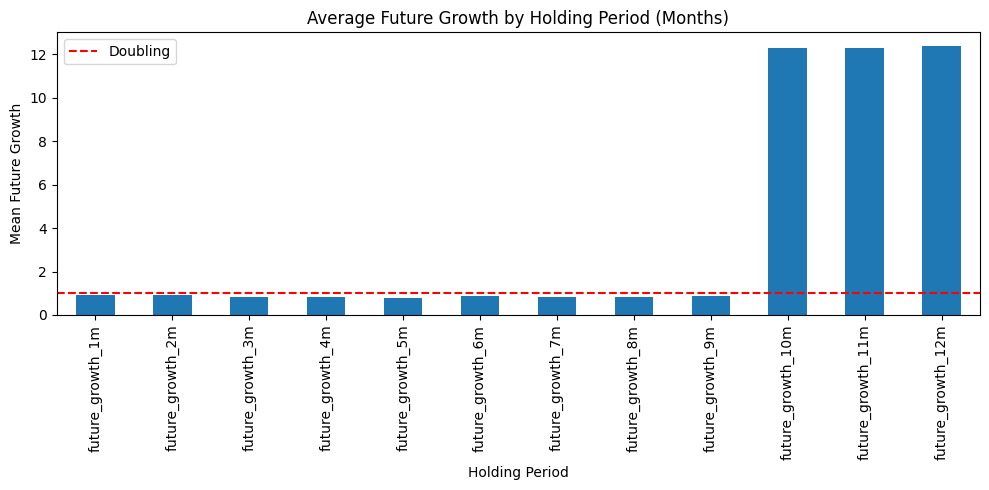

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
mean_returns.plot(kind='bar')
plt.title('Average Future Growth by Holding Period (Months)')
plt.xlabel('Holding Period')
plt.ylabel('Mean Future Growth')
plt.axhline(1.0, color='red', linestyle='--', label='Doubling')
plt.legend()
plt.tight_layout()
plt.show()


### Question 4: [Strategy] Simple RSI-Based Trading Strategy


**What is the total profit (in $thousands) you would have earned by investing $1000 every time a stock was oversold (RSI < 25)?**


---

#### Goal:
Apply a simple rule-based trading strategy using the **Relative Strength Index (RSI)** technical indicator to identify oversold signals and calculate profits.

---


#### Steps:

1. **Run the full notebook from Lecture 2 (33 stocks)**  
   - Ensure you can generate the merged DataFrame containing:  
     - OHLCV data  
     - Technical indicators  
     - Macro indicators  
   - Focus on getting **RSI** computed using **Code Snippets 8 and 9**.  
   - This process is essential and will help during the capstone project.

2. **Alternative (if tech indicators fail to generate):**  
   Download precomputed data using this snippet:

   ```python
   import gdown
   import pandas as pd

   file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
   gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
   df = pd.read_parquet("data.parquet", engine="pyarrow")

3. **RSI Strategy Setup:**  
   - RSI is already available in the dataset as a field.  
   - The threshold for **oversold** is defined as `RSI < 25`.

4. **Filter the dataset by RSI and date:**  
   ```python
   rsi_threshold = 25
   selected_df = df[
       (df['rsi'] < rsi_threshold) &
       (df['Date'] >= '2000-01-01') &
       (df['Date'] <= '2025-06-01')
   ]
5. **Calculate Net Profit Over 25 Years:**  
   - Total number of trades: **1568**  
   - For each trade, you invest **$1000**  
   - Use the 30-day forward return (`growth_future_30d`) to compute net earnings:  
     ```python
     net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()
     ```

   - **Final Answer:**  
     What is the **net income in $K** (i.e., in thousands of dollars) that could be earned using this RSI-based oversold strategy from 2000–2025?

In [26]:
import gdown
import pandas as pd

file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")

Downloading...
From (original): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-
From (redirected): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-&confirm=t&uuid=d80f1765-f273-4ec0-89e7-169fa3070722
To: c:\Users\drish\Cursor\stock-market-analytics\02-dataframe-analysis\data.parquet
100%|██████████| 130M/130M [00:13<00:00, 9.95MB/s] 


In [28]:
df.head()

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.059598,0.062791,0.059598,0.061726,3.081600e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.061726,0.063323,0.061726,0.062791,1.331712e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.062791,0.063323,0.060662,0.061194,6.776640e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.061194,0.061726,0.059598,0.060130,4.789440e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
rsi_threshold = 25

selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
]

In [30]:
selected_df

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
3668,20.056772,20.114241,19.405453,19.673643,99915200.0,0.0,0.0,MSFT,2000,2000-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3669,19.692798,19.807736,19.060636,19.309669,69037800.0,0.0,0.0,MSFT,2000,2000-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3680,18.256067,18.332693,17.317403,17.336559,85374000.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3681,17.279087,17.336557,16.704395,16.991741,136453400.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3682,17.010902,17.547282,16.934277,16.972589,81099400.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,797.393417,806.609179,764.362578,769.289795,7251950.0,0.0,0.0,LT.NS,2020,2020-03-01,...,0.764911,0.515014,0.457056,0.336604,1.181878,1.234663,1.245515,0.610451,0.857647,1.514674
4406,774.673304,800.951963,758.522860,788.998840,6130185.0,0.0,0.0,LT.NS,2020,2020-03-01,...,0.753842,0.491171,0.431611,0.320580,1.001225,1.186226,1.114145,0.643468,0.862000,1.538415
4407,738.175133,739.041975,644.192390,660.662170,7308612.0,0.0,0.0,LT.NS,2020,2020-03-01,...,0.813666,0.496236,0.434706,0.322131,1.100520,1.035093,1.279557,0.663996,0.876243,1.595238
4408,698.550405,699.244329,621.756122,654.971985,7110384.0,10.0,0.0,LT.NS,2020,2020-03-01,...,0.802068,0.509668,0.437480,0.319412,1.049637,1.088881,1.288802,0.678603,0.925726,1.699390


In [31]:
net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()
net_income_k = net_income / 1000



print(f"Net income using RSI < 25 strategy from 2000 to 2025: ${net_income_k:.2f}K")


Net income using RSI < 25 strategy from 2000 to 2025: $24.30K


In [32]:
thresholds = [20, 25, 30, 35]
results = []

for t in thresholds:
    filtered = df[(df['rsi'] < t) & (df['Date'] >= '2000-01-01') & (df['Date'] <= '2025-06-01')]
    net_income = 1000 * (filtered['growth_future_30d'] - 1).sum()
    num_trades = len(filtered)
    results.append({'RSI Threshold': t, 'Net Income ($)': net_income, 'Number of Trades': num_trades})

results_df = pd.DataFrame(results)
print(results_df)


   RSI Threshold  Net Income ($)  Number of Trades
0             20    13973.809168               455
1             25    24295.523125              1568
2             30    65805.589607              5206
3             35   130714.323902             13216


In [33]:
results_df['Avg Income per Trade ($)'] = results_df['Net Income ($)'] / results_df['Number of Trades']
print(results_df)


   RSI Threshold  Net Income ($)  Number of Trades  Avg Income per Trade ($)
0             20    13973.809168               455                 30.711669
1             25    24295.523125              1568                 15.494594
2             30    65805.589607              5206                 12.640336
3             35   130714.323902             13216                  9.890612


## Q5. [Exploratory, Optional] Predicting a Positive-Return IPO

Most of the strategies for investing in IPOs deliver **negative average and median returns** (and even 75% quantiles).

**Question:**  
How would you change the strategy if you want to **increase the profitability**?

> This is an open-ended brainstorming question — propose ideas for identifying IPOs with positive future returns or building a more effective trading strategy.
     

Filter for quality companies: Invest only in IPOs from companies with strong revenue growth, solid financials, and a unique or defensible business model.

Invest in IPOs with top-tier underwriters: Prioritize IPOs managed by reputable investment banks, as these tend to have better due diligence and market support.

Focus on outperforming sectors or themes: Concentrate on IPOs within sectors or themes that are currently showing strong momentum, such as technology or renewable energy.

Avoid IPOs with excessive hype or overvaluation: Be cautious of IPOs that are priced far above industry averages or have received an unusual amount of media hype.

Consider only IPOs showing strong early trading support: Look for IPOs that demonstrate stable or rising prices and high trading volume in the days immediately after listing.

Wait until after the lockup period to invest: Delay investing until after the IPO lockup period expires to avoid potential price drops from insider selling.

Use market timing: Enter IPO trades primarily during bullish market phases, when overall investor sentiment and risk appetite are higher.

Apply quantitative/machine learning models to predict winners: Utilize data-driven models to analyze historical IPO outcomes and identify patterns linked to positive returns.

Monitor insider activity and institutional backing: Favor IPOs where insiders are buying shares or where there is significant participation from respected institutional investors.

Implement risk management (e.g., stop-loss orders): Protect your capital by setting predefined exit points to limit losses on underperforming IPOs.

Consider post-IPO dip opportunities instead of buying at debut: Wait for possible price corrections after the initial trading excitement before making a purchase.

Avoid sectors with historically poor IPO performance: Exclude IPOs from sectors that have a track record of delivering weak post-IPO returns, such as low-quality biotech or certain cyclical industries.